# Version

* `v3`: efficientnet_b4_ns
* `v2`: efficientnet_b4_ns
* `v1`: efficientnet_b4_ns

# importing libraries

In [1]:
timm_path = "../input/timm-pytorch-image-models/pytorch-image-models-master"
import sys
sys.path.append(timm_path)
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from tqdm.notebook import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
train  =  pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv") 
is_normal_df = train.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
is_normal_df.head()

,image_id,num_normal_annotations
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,0


To understand this piece of code above go to the awesome notebook of @corochann https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline/notebook, this peice of code was taken from his notebook.

In [4]:
def change(x):
    if (x==3):
        x=1
    return x
is_normal_df['target'] = is_normal_df['num_normal_annotations'].apply(lambda x: change(x))
df = is_normal_df[["image_id","target"]]
df.head()

,image_id,target
0,000434271f63a053c4128a0ba6352c7f,1
1,00053190460d56c53cc3e57321387478,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,1
4,0007d316f756b3fa0baea2ff514ce945,0


# splitting

In [5]:
from sklearn.model_selection import StratifiedKFold
skf  =  StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
folds = df.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.target)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)    



In [6]:
folds.image_id=folds.image_id+".png"
img_path = "../input/vinbigdata/train"
df_paths = [os.path.join(img_path,x) for x in folds.image_id]
folds['path'] = df_paths
folds.head()

,image_id,target,fold,path
0,000434271f63a053c4128a0ba6352c7f.png,1,0,../input/vinbigdata/train/000434271f63a053c412...
1,00053190460d56c53cc3e57321387478.png,1,3,../input/vinbigdata/train/00053190460d56c53cc3...
2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0,../input/vinbigdata/train/0005e8e3701dfb1dd93d...
3,0006e0a85696f6bb578e84fafa9a5607.png,1,3,../input/vinbigdata/train/0006e0a85696f6bb578e...
4,0007d316f756b3fa0baea2ff514ce945.png,0,1,../input/vinbigdata/train/0007d316f756b3fa0bae...


# Transforms

In [7]:
train_aug = A.Compose(
    [  

        A.Resize(380,380,p=1.0),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(rotate_limit=10, p=0.5),
        A.Blur(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        
#         A.CLAHE(clip_limit=4.0, p=0.85),
        A.HueSaturationValue(p=0.5),
        A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0)
    ]
)
val_aug = A.Compose(
    [
         A.Resize(380,380,p=1.0),
        A.HorizontalFlip(p=0.5),
         A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0),
    ]
)

In [8]:
class Xray(Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img_src = self.df.loc[idx,'path']
        image = cv2.imread(img_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        target = self.df.loc[idx,'target']
        
        if (self.augs):
            transformed = self.augs(image=image)
            image = transformed['image']
        
        return image,torch.tensor(target) 


In [9]:
data = Xray(folds,augs = train_aug)
load = DataLoader(data,batch_size = 1)
img,target = next(iter(load))

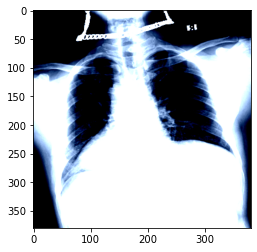

In [10]:
plt.imshow(img.squeeze(0).permute(1,2,0))

# Efficientnet b4 noisy student Model

In [11]:
model=timm.create_model('tf_efficientnet_b4_ns', pretrained=False) # set pretrained=True to use the pretrained weights
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

In [12]:
ss=F.sigmoid(model(torch.randn(3,3,300,300)))
ss

tensor([[0.5378],
        [0.5344],
        [0.5255]], grad_fn=<SigmoidBackward>)

# Helping Functions

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs):
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels= labels.to(device)
        output = model(image)
        batch_size = labels.size(0)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        
            loop.set_description(f"Epoch {e+1}/{epochs}")
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'train')
        
            
        except ValueError:
            pass
        
        
       
        
    return losses.avg,scores.avg

In [15]:
def val_one_epoch(loader,model,optimizer,criterion):
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output = model(image)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'valid')
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        except ValueError:
            pass
        
        
        
        
        
    
        
    return losses.avg,scores.avg

# Training loop

In [16]:
def fit(model,fold_n,training_batch_size=8,validation_batch_size=8):
    
    train_data=folds[folds.fold != fold_n]
    val_data=folds[folds.fold == fold_n]
    train_data= Xray(train_data.reset_index(drop=True),augs = train_aug)
    val_data= Xray(val_data.reset_index(drop=True),augs = val_aug)
    
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=0,
                        batch_size=training_batch_size)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=0,
                        batch_size=validation_batch_size)
    model = model
    model.to(device)
    criterion=nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 3,verbose = True)
    epochs= 12
    
    best_acc = 0
    
    loop = range(epochs)
    for e in loop:
        
        train_loss,train_auc = train_one_epoch(train_loader,model,optimizer,criterion,e,epochs)
         #scheduling step if given
    
        #scheduler.step()
        
        print(f'For epoch {e+1}/{epochs}')
        print(f'average train_loss {train_loss}')
        print(f'average train_auc {train_auc}' )
        
        val_loss,val_auc = val_one_epoch(valid_loader,model,optimizer,criterion)
        
        scheduler.step(val_loss)
        
        print(f'avarage val_loss { val_loss }')
        print(f'avarage val_auc {val_auc}')
        
        
        
        
        if (val_auc>best_acc):
            best_acc =val_auc
            print(f'saving model for {best_acc}')
            torch.save(model.state_dict(),OUTPUT_DIR+ f'Fold {fold_n} model with val_acc {best_acc}.pth') 

In [17]:
fit(model,0)

  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 1/12
average train_loss 0.5635807943586326
average train_auc 0.695755090021873


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.6207274084974844
avarage val_auc 0.8670646067415733
saving model for 0.8670646067415733


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 2/12
average train_loss 0.40943090800867704
average train_auc 0.8858368971252061


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.30578396629981613
avarage val_auc 0.9396585741037995
saving model for 0.9396585741037995


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 3/12
average train_loss 0.36394229340284745
average train_auc 0.9151535419821626


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.2614969366460285
avarage val_auc 0.9590690208667737
saving model for 0.9590690208667737


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 4/12
average train_loss 0.33401250763367607
average train_auc 0.929955772573882


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.2892515797617981
avarage val_auc 0.9367659844836815


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 5/12
average train_loss 0.3147971264257561
average train_auc 0.9379614576982991


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.3092082304660273
avarage val_auc 0.946406835205993


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 6/12
average train_loss 0.29871046157325604
average train_auc 0.9438254646587968


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.26344801039759363
avarage val_auc 0.9617108079186734
saving model for 0.9617108079186734


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 7/12
average train_loss 0.28585418871872365
average train_auc 0.9499716149805107


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.2594855215107457
avarage val_auc 0.9587028491171754


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 8/12
average train_loss 0.2682189847873353
average train_auc 0.9488720699845522


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.21304777236341427
avarage val_auc 0.9644963884430181
saving model for 0.9644963884430181


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 9/12
average train_loss 0.2516145579817868
average train_auc 0.9599899598393571


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.21885452197676294
avarage val_auc 0.9672351524879617
saving model for 0.9672351524879617


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 10/12
average train_loss 0.24446879304162447
average train_auc 0.964187982340848


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.2160124538801192
avarage val_auc 0.9674374665596573
saving model for 0.9674374665596573


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 11/12
average train_loss 0.24158450945512822
average train_auc 0.9617883673958432


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.19727826007678476
avarage val_auc 0.9770365168539329
saving model for 0.9770365168539329


  0%|          | 0/1500 [00:00<?, ?it/s]

For epoch 12/12
average train_loss 0.22701353129719642
average train_auc 0.9635965580261947


  0%|          | 0/375 [00:00<?, ?it/s]

avarage val_loss 0.20460084855185007
avarage val_auc 0.9761771000535049


Not training further epochs due to GPU constraints
#To get a idea of this full pipeline, head over to https://www.kaggle.com/mrinath/another-simple-and-fast-pytorch-pipeline
#say_my_name